In [1]:
%%capture
%pip install transformers
%pip install torch
%pip install matplotlib
%pip install sklearn
%pip install tensorflow
%pip install torchvision
%pip install utils
%pip install statsmodels

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for time series analysis
from statsmodels.graphics.tsaplots import plot_acf

# Importing scikit-learn modules for data preprocessing, modeling, and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Importing TensorFlow and Keras modules for neural network modeling
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)

# Create a DataFrame for stock data
stock2 = pd.DataFrame()

# Generate random binary values and create a cumulative sum to simulate a random walk
stock2.loc[:, "random_number"] = np.random.choice([-1, 1], size=299, replace=True)
stock2.loc[:, "random_walk"] = stock2["random_number"].cumsum()

# Add a trend to the random walk to simulate stock prices
stock2.loc[:, "Close"] = stock2["random_walk"] + 120

In [3]:
# loading data
data = pd.read_csv("LoadForecasting.csv", parse_dates=[0], index_col=0)

# Display the start of the loaded data
data.head()

,load,temperature
date,,
2015-01-01 00:00:00-06:00,6.378,3.22
2015-01-01 01:00:00-06:00,6.134,3.33
2015-01-01 02:00:00-06:00,6.420,3.14
2015-01-01 03:00:00-06:00,6.129,2.69
2015-01-01 04:00:00-06:00,6.687,2.53


In [4]:
# Accessing the index of the dataset 'data' to retrieve timestamps representing dates and times of observations
data.index

DatetimeIndex(['2015-01-01 00:00:00-06:00', '2015-01-01 01:00:00-06:00',
               '2015-01-01 02:00:00-06:00', '2015-01-01 03:00:00-06:00',
               '2015-01-01 04:00:00-06:00', '2015-01-01 05:00:00-06:00',
               '2015-01-01 06:00:00-06:00', '2015-01-01 07:00:00-06:00',
               '2015-01-01 08:00:00-06:00', '2015-01-01 09:00:00-06:00',
               ...
               '2016-12-31 14:00:00-06:00', '2016-12-31 15:00:00-06:00',
               '2016-12-31 16:00:00-06:00', '2016-12-31 17:00:00-06:00',
               '2016-12-31 18:00:00-06:00', '2016-12-31 19:00:00-06:00',
               '2016-12-31 20:00:00-06:00', '2016-12-31 21:00:00-06:00',
               '2016-12-31 22:00:00-06:00', '2016-12-31 23:00:00-06:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-360)]', name='date', length=17544, freq=None)

<AxesSubplot:xlabel='date'>

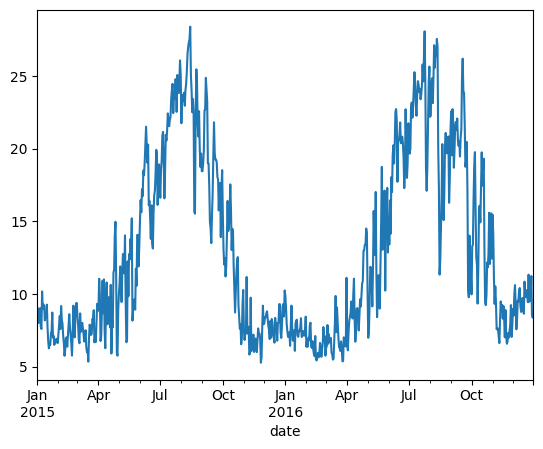

In [5]:
# Resample the 'load' data to a daily frequency (1 day) and 
# calculate the mean value for each day
# Plotting this data provides a visualization 
# of the daily mean load over time
data.load.resample("1D").mean().plot()

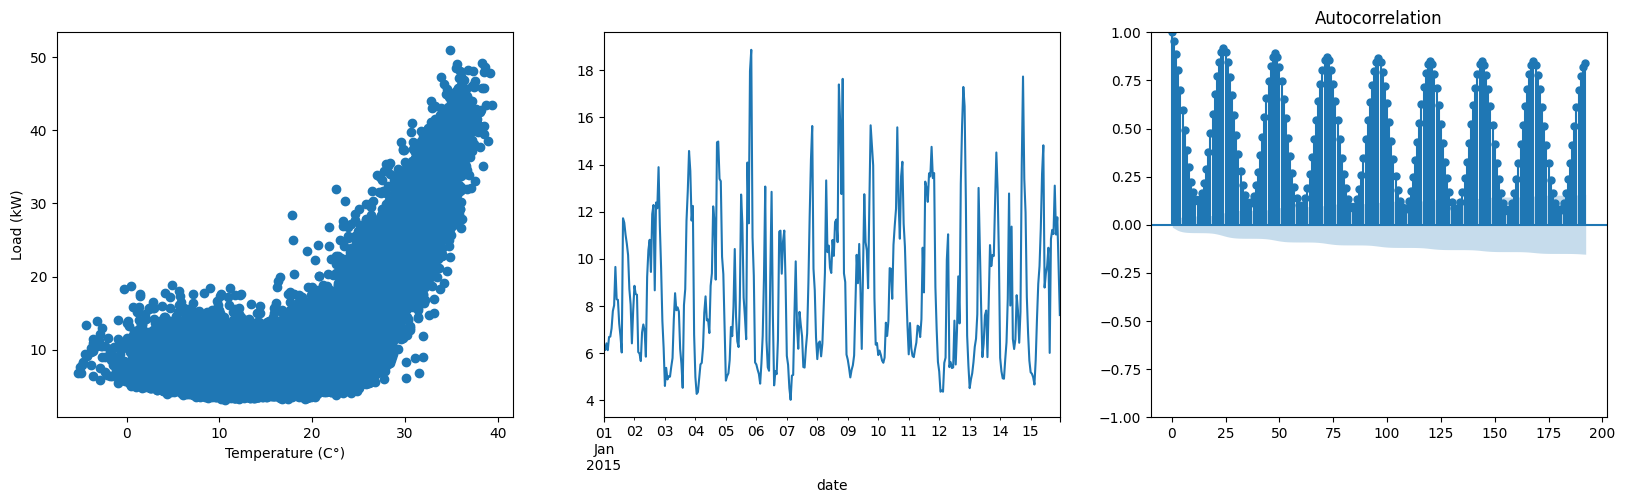

In [6]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Reading the data from the provided URL, parsing dates in the first column, and setting the first column as the index
data = pd.read_csv("LoadForecasting.csv", parse_dates=[0], index_col=0)

# Creating a figure with subplots, containing 1 row and 3 columns, setting the size of the figure
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Scatter plot of temperature vs. load, using the data from the DataFrame, on the first subplot (ax[0])
ax[0].scatter(data.temperature, data.load)

# Setting the label for the x-axis of the scatter plot as "Temperature (C°)"
ax[0].set_xlabel("Temperature (C°)")

# Setting the label for the y-axis of the scatter plot as "Load (kW)"
ax[0].set_ylabel("Load (kW)")

# Plotting the load data for the specified date range (Jan 1st, 2015 to Jan 15th, 2015,i.e. 2 weeks) on the second subplot (ax[1])
data["2015-01-01":"2015-01-15"].load.plot(ax=ax[1])

# Calculating and plotting the autocorrelation function (ACF) of the load data with a lag of 8*24 (8 days) on the third subplot (ax[2])
acf_fig = plot_acf(data.load, ax=ax[2], lags=8*24)

In [7]:

# Adding cyclical encoding for hour of the day and month of the year
# These transformations are applied using sine and cosine functions
data["hour_x"] = np.sin(np.radians((360/24) * data.index.hour))
data["hour_y"] = np.cos(np.radians((360/24) * data.index.hour))
data["month_x"] = np.sin(np.radians((360/12) * data.index.month))
data["month_y"] = np.cos(np.radians((360/12) * data.index.month))

# Adding temperature-related variables: the rolling mean of the
# temperature for the last day and the temperature lagged by one value
# This approach may better capture the recency effect
data["temperature_rolling_mean"] = data.loc[:, "temperature"].rolling(window=24).mean()
data["temperature_lag_1"] = data.temperature.shift(1)

# Adding load lags up to one day, this allows us to incorporate 
# past load values as features in our dataset. 
MAX_LAG = 24
for lag in range(1, MAX_LAG+1):
    data["load_lag_" + str(lag)] = data["load"].shift(lag)

# Adding calendar-based variables as categorical data
# This step applies one-hot encoding to categorical variables
data["day_of_week"] = data.index.weekday
data["hour_of_day"] = data.index.hour
data["month_of_year"] = data.index.month
data["weekend"] = data.index.weekday.isin([5, 6])  # Boolean indicator for weekends
data = pd.get_dummies(data, columns=["day_of_week", "hour_of_day", "month_of_year"])  # One-hot encoding for categorical variables
data.head()

,load,temperature,hour_x,hour_y,month_x,month_y,temperature_rolling_mean,temperature_lag_1,load_lag_1,load_lag_2,...,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00-06:00,6.378,3.22,0.000000,1.000000,0.5,0.866025,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00-06:00,6.134,3.33,0.258819,0.965926,0.5,0.866025,NaN,3.22,6.378,NaN,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00-06:00,6.420,3.14,0.500000,0.866025,0.5,0.866025,NaN,3.33,6.134,6.378,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00-06:00,6.129,2.69,0.707107,0.707107,0.5,0.866025,NaN,3.14,6.420,6.134,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00-06:00,6.687,2.53,0.866025,0.500000,0.5,0.866025,NaN,2.69,6.129,6.420,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#printing the columns of data
data.columns

Index(['load', 'temperature', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'temperature_rolling_mean', 'temperature_lag_1', 'load_lag_1',
       'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6',
       'load_lag_7', 'load_lag_8', 'load_lag_9', 'load_lag_10', 'load_lag_11',
       'load_lag_12', 'load_lag_13', 'load_lag_14', 'load_lag_15',
       'load_lag_16', 'load_lag_17', 'load_lag_18', 'load_lag_19',
       'load_lag_20', 'load_lag_21', 'load_lag_22', 'load_lag_23',
       'load_lag_24', 'weekend', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'hour_of_day_0', 'hour_of_day_1', 'hour_of_day_2',
       'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5', 'hour_of_day_6',
       'hour_of_day_7', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14',
       'hour_of_day_15', 'hour_of_day_16', 'hour_of_da

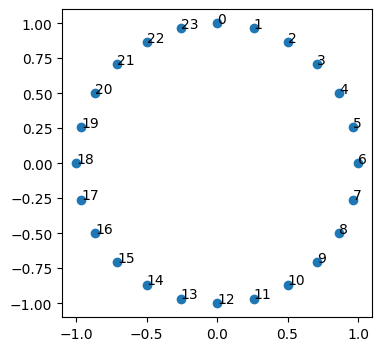

In [9]:
# Creating a scatter plot to visualize the cyclical encoding of hour of the day
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Scatter plot of hour_x and hour_y for the first 24 hours
ax.scatter(data["hour_x"].iloc[:24], data["hour_y"].iloc[:24])

# Annotating each point with the corresponding hour
for h in range(24):
    ax.annotate(data.index.hour[h], (data["hour_x"].iloc[h], data["hour_y"].iloc[h]))

In [10]:
# Creating a DataFrame Y with lagged load values up to 24 hours
H = 24  # Number of hours to shift
Y = pd.DataFrame(index=data.index)

# Shifting the load values for each hour and storing them in separate columns in Y
for h in range(H):
    Y["h_" + str(h)] = data.load.shift(-h)

Data Preprocessing

In [11]:
#standardising numerical and categorical data

scaler = StandardScaler()
numeric_cols = ['temperature'] + [c for c in data.columns if "load_lag" in c]
categorical_cols = [c for c in data.columns if "hour_of_day" in c] + [c for c in data.columns if "day_of_week" in c] + [c for c in data.columns if "month_of_year" in c]
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)
categoricals = data[categorical_cols]

# Concatenating standardized numerical features and categorical 
# features into the final feature matrix
X = pd.concat([numerics, categoricals],axis=1)

Data Cleaning

In [12]:
# Slicing X and Y to exclude rows with missing values due to lagged features and forecast horizon
X, Y = X.iloc[MAX_LAG:-H, :], Y.iloc[MAX_LAG:-H, :]

#Splitting the data into training and testing sets
# The shuffle parameter is set to False to maintain temporal order

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

In [13]:
# Generating naive forecasts by shifting the target variable (load data) 168 time steps (1 week) into the future and selecting the corresponding test index
y_hat_naive = Y.shift(168).loc[X_test.index]

# Generating simple moving average forecasts by averaging the target variable values shifted by 1, 2, 3, and 4 weeks into the future,
# then dividing the sum by 4 to get the average load value per hour, and selecting the corresponding test index
y_hat_sma = np.divide(
    Y.shift(168).loc[X_test.index] + Y.shift(168*2).loc[X_test.index] + Y.shift(168*3).loc[X_test.index] + Y.shift(168*4).loc[X_test.index], 4)


In [14]:
# Define a function to calculate Mean Absolute Percentage Error (MAPE) between true and predicted values
def mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE) between true and predicted values.

    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted target values.

    Returns:
    - MAPE: float, Mean Absolute Percentage Error.
    """
    return mean_absolute_percentage_error(y_true, y_pred) * 100

# Define a function to calculate Root Mean Squared Error (RMSE) between true and predicted values
def rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) between true and predicted values.

    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted target values.

    Returns:
    - RMSE: float, Root Mean Squared Error.
    """
    return mean_squared_error(y_true, y_pred, squared=False)


In [15]:
# Calculate and print the Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE) for the Naive and Simple Moving Average (SMA) models
print(f"MAPE Naive: {mape(y_test, y_hat_naive):.2f}, SMA: {mape(y_test, y_hat_sma):.2f}")
print(f"RMSE Naive: {rmse(y_test, y_hat_naive):.2f}, SMA: {rmse(y_test, y_hat_sma):.2f}")

MAPE Naive: 30.36, SMA: 29.17
RMSE Naive: 5.81, SMA: 5.12


In [16]:
# Fit a KNN regression model to the training data
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# Predict the target values for the test data using the trained KNN model
y_hat_knn = pd.DataFrame(model.predict(X_test), index=y_test.index)

# Print the Mean Absolute Percentage Error (MAPE) for the SMA and KNN models
print(f"MAPE SMA: {mape(y_test, y_hat_sma):.2f}, KNN: {mape(y_test, y_hat_knn):.2f}")

MAPE SMA: 29.17, KNN: 17.25


In [17]:
# Fit a MultiOutputRegressor with Ridge regression to the training data
model = MultiOutputRegressor(Ridge())
model.fit(X_train, y_train)

# Predict the target values for the test data using the trained Ridge regression model
y_hat_linear = pd.DataFrame(model.predict(X_test), index=y_test.index)

# Print the Mean Absolute Percentage Error (MAPE) for the KNN and Ridge regression models
print(f"KNN: {mape(y_test, y_hat_knn):.2f}, Ridge Regression: {mape(y_test, y_hat_linear):.2f}")

KNN: 17.25, Ridge Regression: 18.13


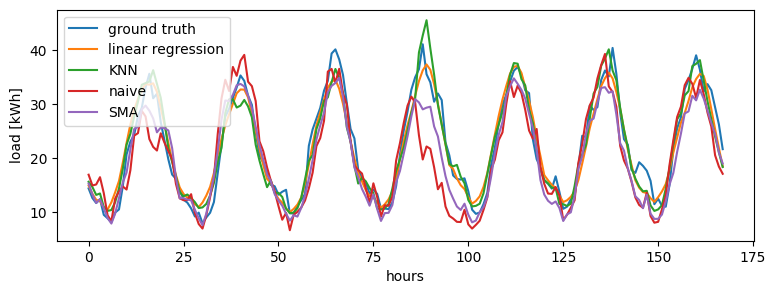

In [18]:
# Create a subplot for plotting the comparison of load forecasts for the first 7 hours of the day
fig, ax = plt.subplots(figsize=(9,3))

# Plot the ground truth load values for the first 7 hours of the day
ax.plot(y_test[y_test.index.hour==0].iloc[:7].values.reshape(-1,1), label='ground truth')

# Plot the load forecasts using linear regression for the first 7 hours of the day
ax.plot(y_hat_linear[y_hat_linear.index.hour==0].iloc[:7].values.reshape(-1,1), label='linear regression')

# Plot the load forecasts using KNN regression for the first 7 hours of the day
ax.plot(y_hat_knn[y_hat_knn.index.hour==0].iloc[:7].values.reshape(-1,1), label='KNN')

# Plot the load forecasts using naive method for the first 7 hours of the day
ax.plot(y_hat_naive[y_hat_naive.index.hour==0].iloc[:7].values.reshape(-1,1), label='naive')

# Plot the load forecasts using simple moving average for the first 7 hours of the day
ax.plot(y_hat_sma[y_hat_sma.index.hour==0].iloc[:7].values.reshape(-1,1), label='SMA')

# Set the y-axis label to 'load [kWh]' and the x-axis label to 'hours'
ax.set_ylabel('load [kWh]')
ax.set_xlabel('hours')

# Add a legend to the plot
plt.legend()

In [19]:
# Initialize StandardScaler for scaling numeric features
scaler = StandardScaler()

# Define numeric columns including temperature, hour_x, hour_y, month_x, month_y, and load lags
numeric_cols = ["temperature", "hour_x", "hour_y", "month_x", "month_y"] + [c for c in data.columns if "load_lag" in c]

# Scale the numeric features using StandardScaler
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)

# Select the sine/cosine encoded features for modeling
X_sine = numerics

# Remove rows with missing values and set the range for model inputs and outputs
X_sine = X_sine.iloc[MAX_LAG:-H,:]

# Split the data into training and testing sets, preserving temporal order
X_sine_train, X_sine_test, _, _ = train_test_split(X_sine, Y, test_size=0.25, shuffle=False)

In [20]:
#One-hot encoding VS. Sine cos

# Initialize KNN regressor for modeling using one-hot encoding
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# Predict the target variable for the testing data using the trained model
y_hat = knn.predict(X_test)

# Calculate the Mean Absolute Percentage Error (MAPE) for the KNN model with one-hot encoding
print(f"MAPE One-hot encoding: {mape(y_test, y_hat):.2f}")

# Reinitialize KNN regressor for modeling using sinecos encoding
knn = KNeighborsRegressor()

# Fit the KNN model on the training data using sinecos encoded features
knn.fit(X_sine_train, y_train)

# Predict the target variable for the testing data using the trained model
y_hat = knn.predict(X_sine_test)

# Calculate the MAPE for the KNN model with sinecos encoding
print(f"MAPE Sine/Cose Encoding: {mape(y_test, y_hat):.2f}")

MAPE One-hot encoding: 17.25
MAPE Sine/Cose Encoding: 18.23


In [21]:
# Determine the number of features in the test data
num_features = X_test.shape[1]

# Initialize a Sequential model
model = Sequential()

# Add an input layer with the specified number of features
model.add(Input(shape=(num_features,)))  # Provide the shape as a tuple

# Add a hidden layer with 15 units and relu activation function
model.add(Dense(units=15, activation='relu'))

# Add another hidden layer with 5 units and relu activation function
model.add(Dense(units=5, activation='relu'))

# Add the output layer with H units and linear activation function
model.add(Dense(units=H, activation='linear'))

# Compile the model using mean squared error as the loss function, Adam optimizer, and MSE as the metric
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error"])

# Print a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │         1,035 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259 (4.92 KB)

 Trainable params: 1,259 (4.92 KB)

 Non-trainable params: 0 (0.00 B)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
MAPE ANN: 17.63


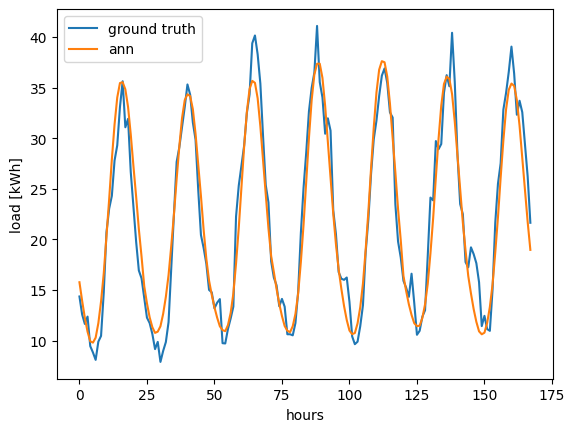

In [22]:
# Train the artificial neural network (ANN) model
history = model.fit(X_train.values.astype("float32"),
                    y_train.values.astype("float32"),
                    validation_split=0.10,
                    epochs=100,
                    batch_size=16,
                    verbose=False
)

# Make predictions using the trained ANN model
y_hat_ann = pd.DataFrame(model.predict(X_test.astype("float32")), index=y_test.index)
print(f"MAPE ANN: {mape(y_test, y_hat_ann):.2f}")

# Plotting the ground truth and ANN predictions
fig, ax = plt.subplots()
ax.plot(y_test[y_test.index.hour==0].iloc[:7].values.reshape(-1,1),label='ground truth')
ax.plot(y_hat_ann[y_hat_ann.index.hour==0].iloc[:7].values.reshape(-1,1),label='ann')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('hours')
plt.legend()

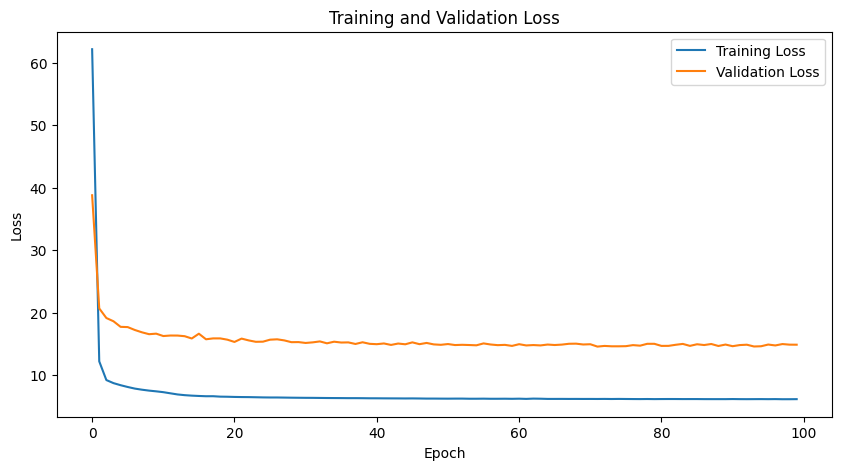

In [23]:
# Create a figure and axis object for plotting training and validation loss
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot training loss
ax.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
ax.plot(history.history['val_loss'], label='Validation Loss')

# Set title for the plot
ax.set_title('Training and Validation Loss')

# Set label for x-axis
ax.set_xlabel('Epoch')

# Set label for y-axis
ax.set_ylabel('Loss')

# Show legend
ax.legend()

Validation loss may be due to overfitting.

In [24]:
# Calculate the errors between predicted values and ground truth for the first output variable
step_ahead_errors = y_hat_knn.iloc[:, 0] - y_test.iloc[:, 0]

Mean: -0.41


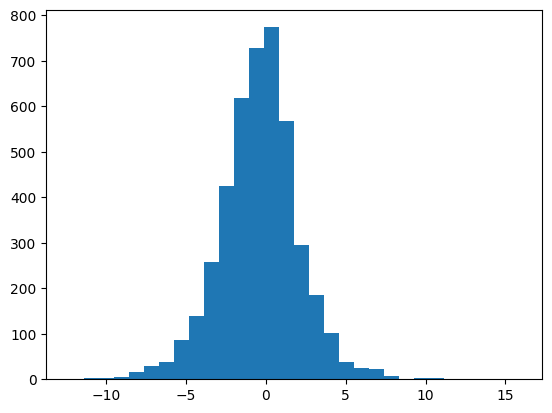

In [25]:
# Calculate the errors between predicted values and ground truth for the first output variable
step_ahead_errors = y_hat_knn.iloc[:, 0] - y_test.iloc[:, 0]

# Plot a histogram of the step-ahead errors with 30 bins
plt.hist(step_ahead_errors, bins=30)

# Print the mean of the step-ahead errors
print(f"Mean: {step_ahead_errors.mean():.2f}")

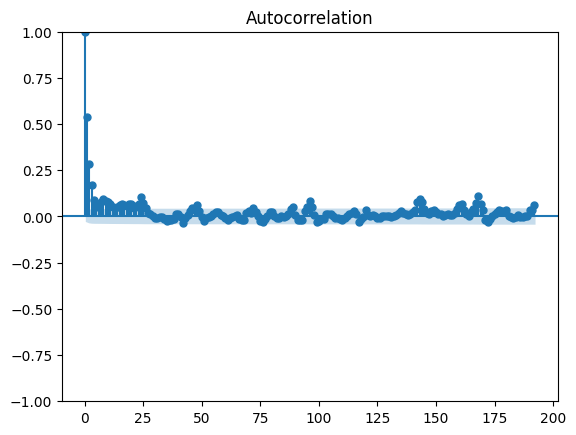

In [26]:
# Plot the autocorrelation function (ACF) of the step-ahead errors with a lag of 8 days
acf = plot_acf(step_ahead_errors, lags=8*24)

Evaluation

<AxesSubplot:xlabel='Date'>

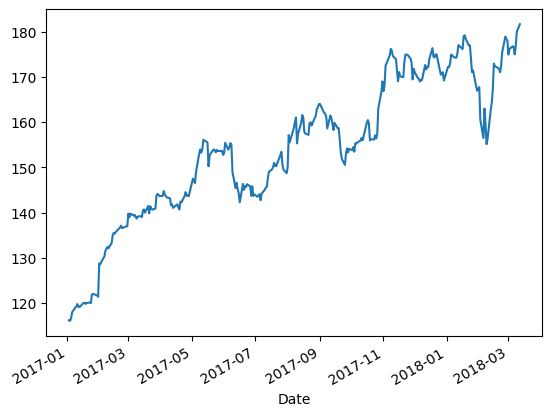

In [27]:
# Load data for Apple stock price dataset
STOCK_URL = "https://raw.githubusercontent.com/AbdelrahmanRadwan/AAPL-Stock-Prices-Analysis/master/DataSet/Dataset.csv"

# Read the dataset into a DataFrame, parsing dates and setting the index to the first column
apple = pd.read_csv(STOCK_URL, parse_dates=[0], index_col=0)

# Plot the closing prices of Apple stock from the year 2017 onwards
apple["2017":]["Close"].plot(label="Apple")

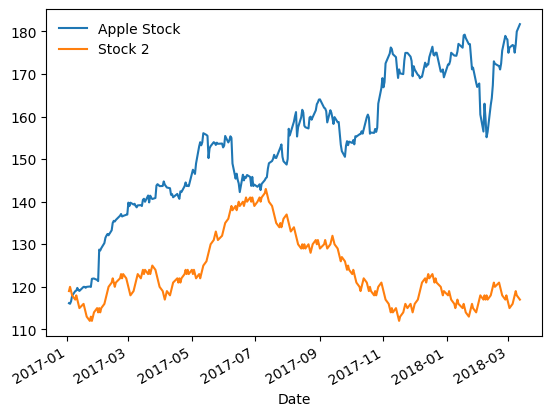

In [28]:
# Plot the closing prices of Apple stock from the year 2017 onwards
ax = apple["2017":]["Close"].plot(label="Apple Stock")

# Plot the closing prices of another stock (assuming it's stored in a DataFrame named stock2)
ax.plot(apple["2017":]["Close"].index, stock2["Close"], label="Stock 2")

# Display legend without a frame
ax.legend(frameon=False)

In [29]:
MAX_LAG = 7
X_apple = pd.DataFrame(index=apple["2017":].index)
for lag in range(0, MAX_LAG):
    X_apple["Close_lag_" + str(lag)] = apple["2017":]["Close"].shift(lag)

X_stock2 = pd.DataFrame(index=stock2.index)
for lag in range(0, MAX_LAG):
    X_stock2["Close_lag_" + str(lag)] = stock2["Close"].shift(lag)


Y_apple = apple["2017":].Close.shift(-1)
Y_stock2 = stock2.Close.shift(-1)

X_apple, Y_apple = X_apple.iloc[MAX_LAG:-1,:].values, Y_apple.iloc[MAX_LAG:-1].values
X_stock2, Y_stock2 = X_stock2.iloc[MAX_LAG:-1,:].values, Y_stock2.iloc[MAX_LAG:-1].values

X_train_apple, X_test_apple, y_train_apple, y_test_apple = train_test_split(X_apple, Y_apple , test_size=0.25, shuffle=False)
X_train_stock2, X_test_stock2, y_train_stock2, y_test_stock2 = train_test_split(X_stock2, Y_stock2, test_size=0.25, shuffle=False)

In [30]:
model = Ridge()
model.fit(X_train_apple, y_train_apple)
Y_hat_apple = model.predict(X_test_apple)

model = Ridge()
model.fit(X_train_stock2, y_train_stock2)
Y_hat_stock2= model.predict(X_test_stock2)

MAPE Apple Stock: 1.07%


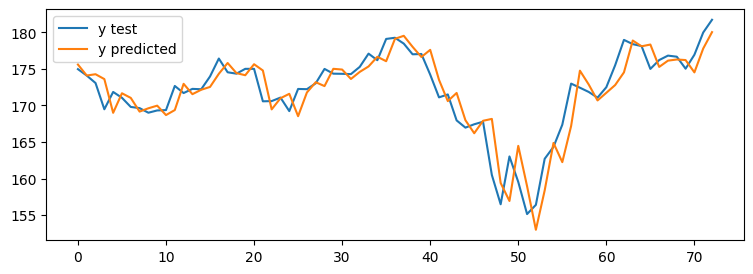

In [31]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_apple,label='y test')
ax.plot(Y_hat_apple,label='y predicted')
plt.legend()

print(f"MAPE Apple Stock: {mape(y_test_apple, Y_hat_apple):.2f}%")

MAPE Stock 2: 0.83%


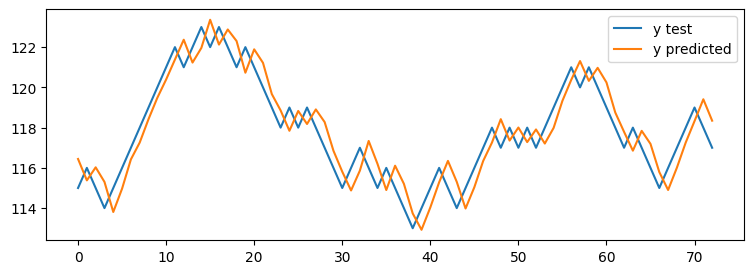

In [32]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_stock2,label='y test')
ax.plot(Y_hat_stock2,label='y predicted')
plt.legend()
print(f"MAPE Stock 2: {mape(y_test_stock2, Y_hat_stock2):.2f}%")

In [33]:
Y_hat_naive_apple = X_test_apple[:,0]
Y_hat_naive_stock2 = X_test_stock2[:,0]

MAPE  Apple Stock: 1.01%


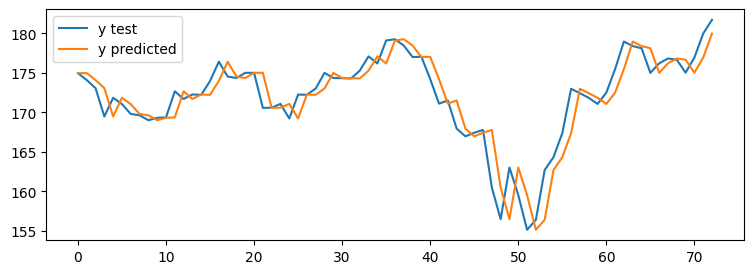

In [34]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_apple,label='y test')
ax.plot(Y_hat_naive_apple,label='y predicted')
plt.legend()

print(f"MAPE  Apple Stock: { mape(y_test_apple, Y_hat_naive_apple):.2f}%")

MAPE Stock 2: 0.85%


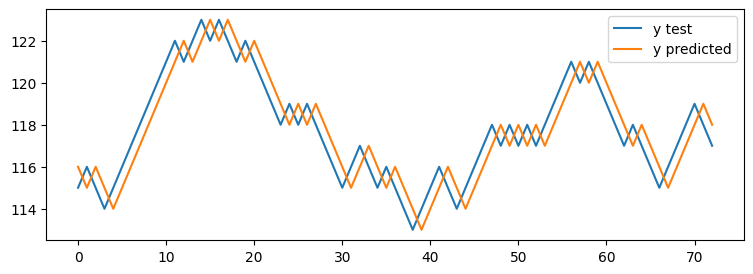

In [35]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_stock2,label='y test')
ax.plot(Y_hat_naive_stock2,label='y predicted')
plt.legend()

print(f"MAPE Stock 2: {mape(y_test_stock2, Y_hat_naive_stock2):.2f}%")

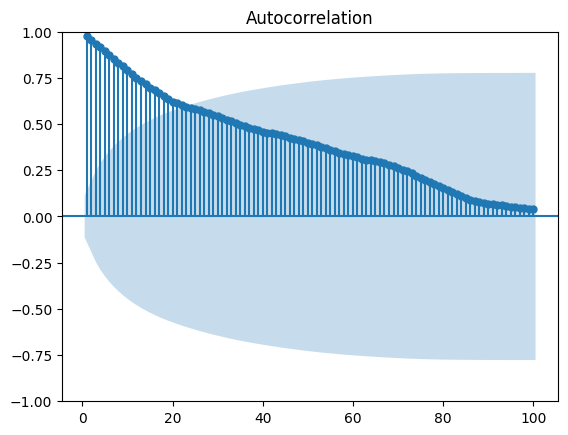

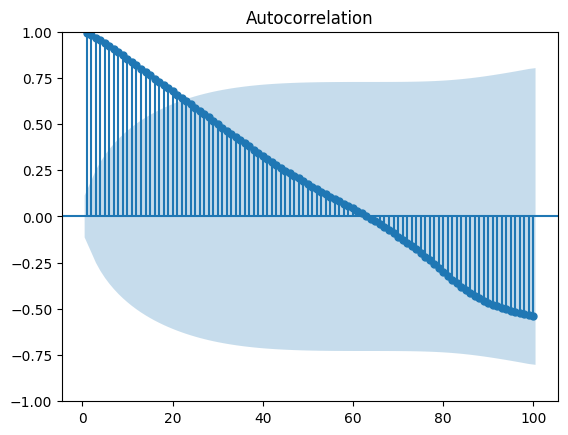

In [36]:
acf = plot_acf(apple["2017":]["Close"], lags=100, zero=False)
acf = plot_acf(stock2["Close"], lags=100, zero=False)

<AxesSubplot:title={'center':'Differenced stock 2 (random walk)'}>

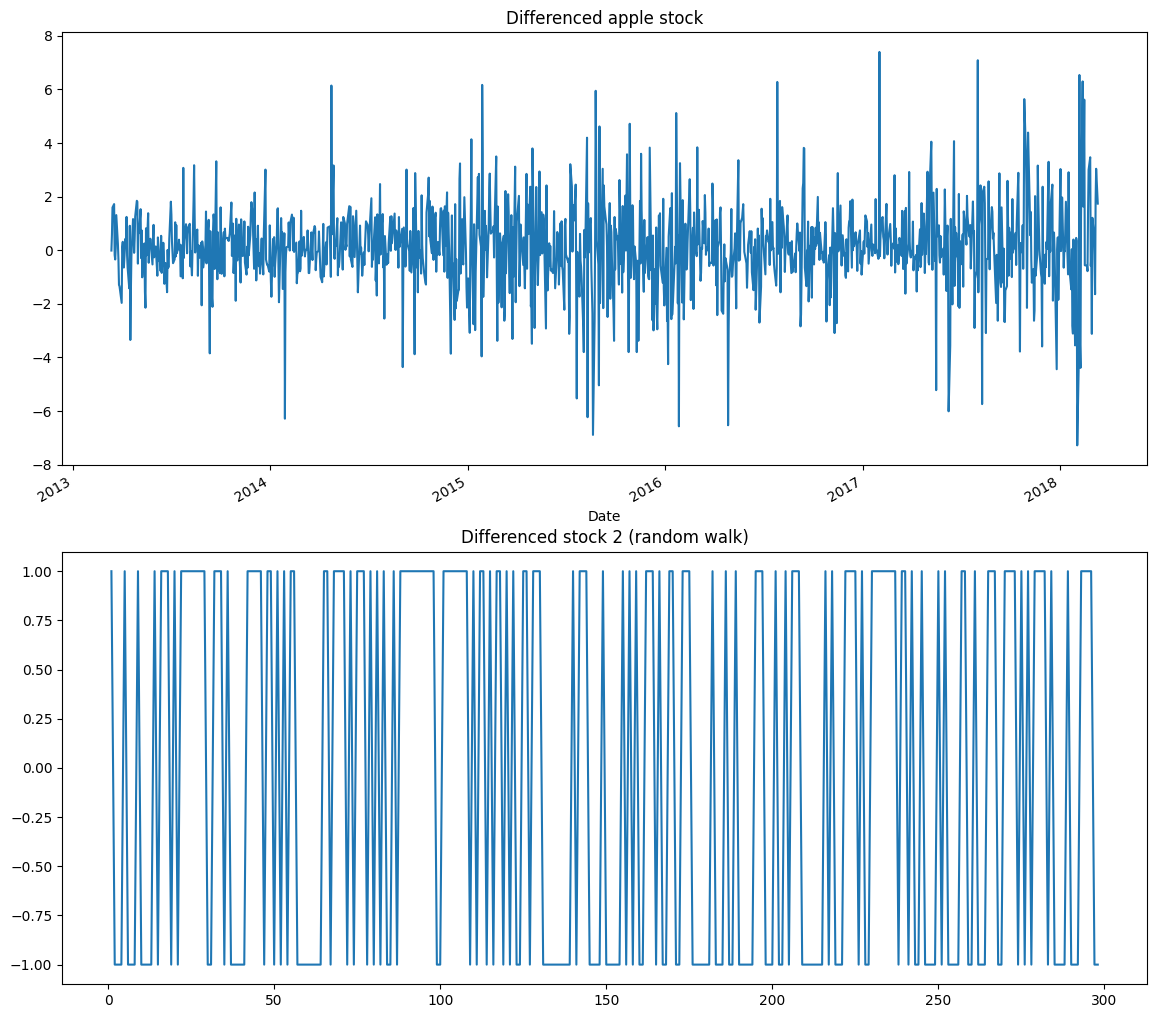

In [37]:
apple_stationary = apple["Close"].diff()[1:]
stock2_stationary = stock2["Close"].diff()[1:]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))
apple_stationary.plot(ax=axes[0], title="Differenced apple stock")
stock2_stationary.plot(ax=axes[1], title="Differenced stock 2 (random walk)")

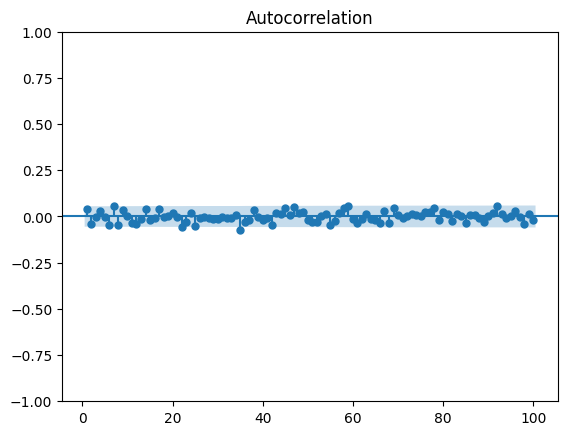

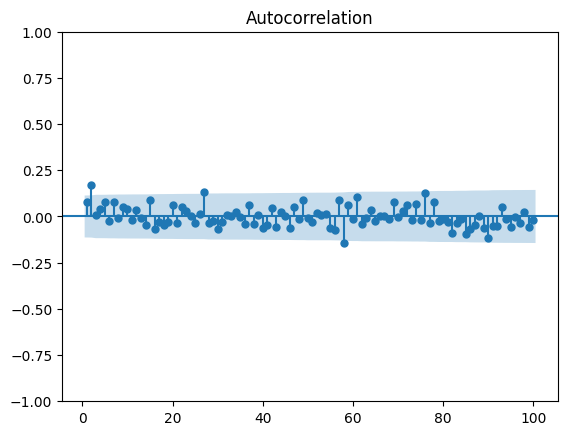

In [38]:
acf = plot_acf(apple_stationary, lags=100, zero=False)
acf = plot_acf(stock2_stationary, lags=100, zero=False)

In [39]:
## this block is from last time
data = pd.read_csv("LoadForecasting.csv", parse_dates=[0], index_col=0)
# add sine/cosine encoding for hour of day and month of the year
data["hour_x"] = np.sin(np.radians((360/24) * data.index.hour))
data["hour_y"] = np.cos(np.radians((360/24) * data.index.hour))
data["month_x"] = np.sin(np.radians((360/12) * data.index.month))
data["month_y"] = np.cos(np.radians((360/12) * data.index.month))

# temperature related variables, the mean of last day and lagged by one value, which may better capture the "recency effect"
data["temperature_rolling_mean"] = data.loc[:,"temperature"].rolling(window=24).mean()
data["temperature_lag_1"] = data.temperature.shift(1)

# Add lags up to one day
MAX_LAG = 24
for lag in range(1, MAX_LAG+1):
    data["load_lag_" + str(lag)] = data["load"].shift(lag)

# add calendar-based variables as categorical data
data["day_of_week"] = data.index.weekday
data["hour_of_day"] = data.index.hour
data["month_of_year"] = data.index.month
data["weekend"] = data.index.weekday.isin([5,6])
data = pd.get_dummies(data, columns=["day_of_week", "hour_of_day", "month_of_year"])

H = 24
Y = pd.DataFrame(index = data.index)
for h in range(H):
    Y["h_" + str(h)] = data.load.shift(-h)

scaler = StandardScaler()
numeric_cols = ['temperature'] + [c for c in data.columns if "load_lag" in c]
categorical_cols = [c for c in data.columns if "hour_of_day" in c] + [c for c in data.columns if "day_of_week" in c] + [c for c in data.columns if "month_of_year" in c]
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)
categoricals = data[categorical_cols]

X = pd.concat([numerics, categoricals],axis=1)
X, Y = X.iloc[MAX_LAG:-H,:], Y.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

In [40]:
N  = 4
knn = KNeighborsRegressor()
knn_parameters = {"n_neighbors" : [3, 6, 12, 18, 24]}

# Using shuffle=False, the KFold represents "blocked cross-validation", i.e. consequitive blocks remain together
gs_cv_block = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=False), n_jobs=-1, return_train_score=True)
gs_cv_block.fit(X_train, y_train)
print(gs_cv_block.best_params_)
y_hat = gs_cv_block.predict(X_test)
print(f"Test MAPE Blocked: {mape(y_test, y_hat):.2f}")

# Using shuffle=True, the KFold represents regular, completely shuffled cross-validation
gs_cv_shuffle = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=True), n_jobs=-1, return_train_score=True)
gs_cv_shuffle.fit(X_train, y_train)
print(gs_cv_shuffle.best_params_)
y_hat = gs_cv_shuffle.predict(X_test)
print(f"Test MAPE Shuffled: {mape(y_test, y_hat):.2f}")

# Sklearn also includes a CV scheme for time series
gs_cv_ts = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=TimeSeriesSplit(n_splits=N), n_jobs=-1, return_train_score=True)
gs_cv_ts.fit(X_train, y_train)
print(gs_cv_ts.best_params_)
y_hat = gs_cv_ts.predict(X_test)
print(f"Test MAPE Time Series CV: {mape(y_test, y_hat):.2f}")

{'n_neighbors': 24}
Test MAPE Blocked: 16.66
{'n_neighbors': 12}
Test MAPE Shuffled: 16.74


/Users/tanushreesudheer/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_neighbors': 24}
Test MAPE Time Series CV: 16.66


<AxesSubplot:xlabel='None-param_n_neighbors', ylabel='level_0'>

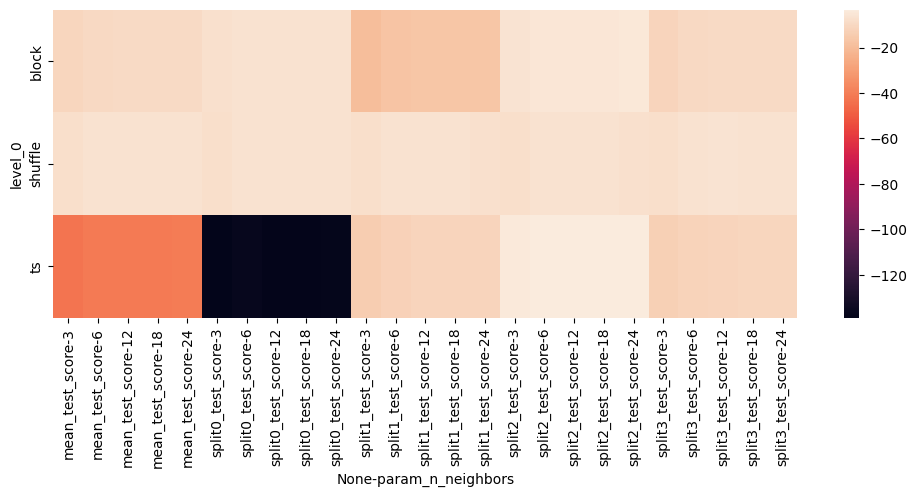

In [41]:
cv_results = pd.concat([pd.DataFrame(gs_cv_ts.cv_results_), pd.DataFrame(gs_cv_shuffle.cv_results_), pd.DataFrame(gs_cv_block.cv_results_)], keys=["ts", "shuffle", "block"]).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(cv_results.pivot(index="level_0", columns="param_n_neighbors", values=["mean_test_score", "split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score"]), ax=ax)